# Imports

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
from qiskit.opflow import PauliOp, SummedOp
from qiskit.opflow.primitive_ops import PrimitiveOp
from Graph7 import Graph7
import random

In [2]:
import networkx.algorithms.approximation.maxcut as maxcut
from QAOACircuit import QAOACircuit
from QAOASimulation import QAOASimulation, SimType

# Build Random Graph

In [3]:
# Build random graph, add edges between vertex pairs with probability input
def build_graph_with_probability(num_vertices, probability):
    if probability < 0 or probability > 1:
        raise ValueError("Probability must be between 0 and 1")

    G = nx.Graph()
    G.add_nodes_from(range(num_vertices))   # Add vertices

    for i in range( num_vertices ):
        for j in range(i + 1, num_vertices ):
            if random.random() < probability:
                G.add_edge(i, j)  # Add edge with probability

    return G

In [4]:
# Define a list of nx graphs of length 5
graphs = [build_graph_with_probability(7, 0.5) for _ in range(5)]

graph_objs = [Graph7(graph, 'Graph {}'.format(i)) for i, graph in enumerate(graphs)]
#G = build_graph_with_probability(7, 0.5)
#for graph in graphs:

#    nx.draw(graph, with_labels=True, font_weight='bold')
#    plt.show()

In [5]:
maxcut.one_exchange(graph_objs[0].graph)

(9, ({2, 3, 5}, {0, 1, 4, 6}))

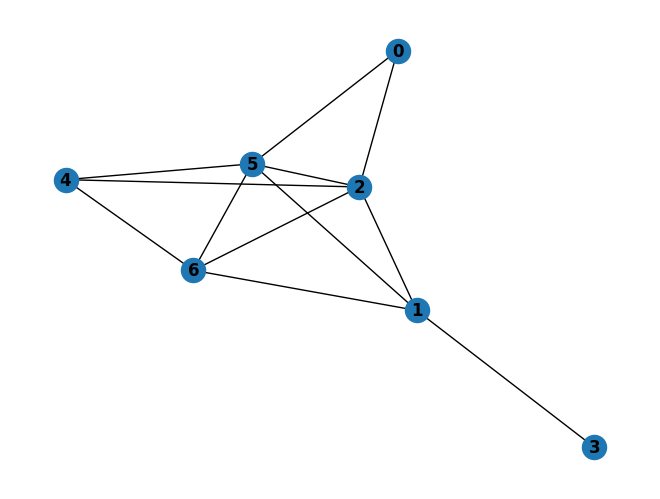

In [6]:
nx.draw(graph_objs[0].graph, with_labels=True, font_weight='bold')
plt.show()

# Attempt at calling simulator object (STATE_VECTOR)

In [7]:
sim_sv = QAOASimulation(SimType.STATE_VECTOR)

C:\Users\maluf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
C:\Users\maluf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


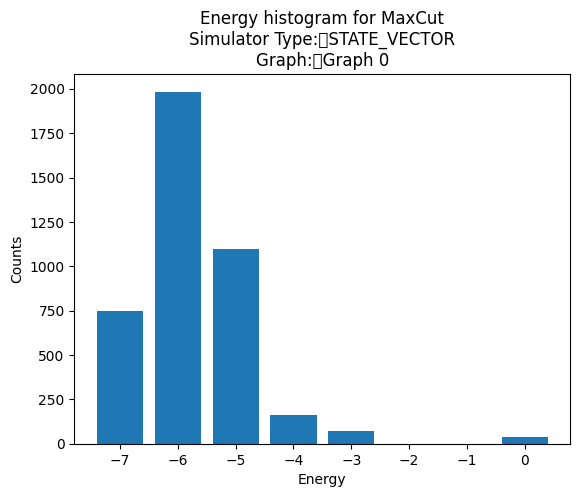

In [8]:
opt_res = sim_sv.get_opt_params(graph_objs[0])
opt_res_counts = sim_sv.run_circuit_optimal_params(opt_res, graph_objs[0])
#sim_sv.best_solution(graph_objs[0], opt_res_counts)

In [9]:
best_cut, best_solution = sim_sv.best_solution(graph_objs[0], opt_res_counts)

Best string: 1001110 with cut: 7


In [9]:
# Build for loop on enumerate of graphs and index
#qaoas = [QAOACircuit(graph, [np.pi/3], [np.pi/2]) for graph in graphs]

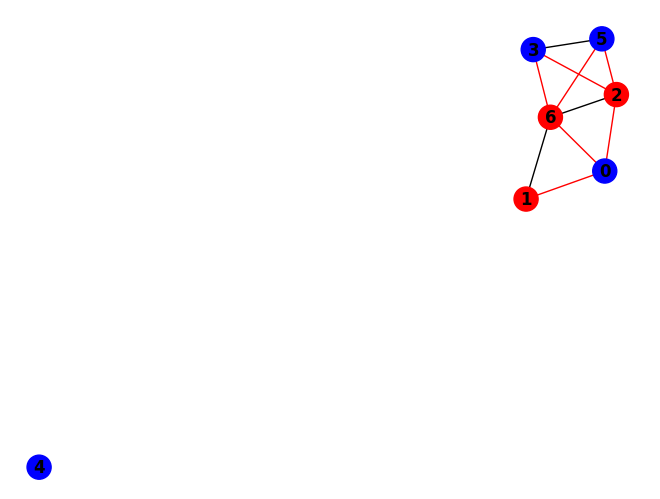

In [13]:
# color the graph nodes by part
G = graph_objs[0].graph
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
cut_edges = [(u, v) for u, v in G.edges() if ((best_solution[u] == '0' and best_solution[v] != '0') or (best_solution[u] != '0' and best_solution[v] == '0'))]

cut_edge_color = 'red'
non_cut_edge_color = 'black'
for edge in G.edges():
    if edge in cut_edges:
        G[edge[0]][edge[1]]['color'] = cut_edge_color
    else:
        G[edge[0]][edge[1]]['color'] = non_cut_edge_color

edge_colors = [G[edge[0]][edge[1]]['color'] for edge in G.edges()]

nx.draw(G, node_color = colors, with_labels=True, font_weight='bold', edge_color=edge_colors)
plt.show()

# Attempt at calling simulator object (NOISY_SIMULATOR)

In [7]:
sim_n = QAOASimulation(SimType.NOISY_SIMULATOR)

C:\Users\maluf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
C:\Users\maluf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


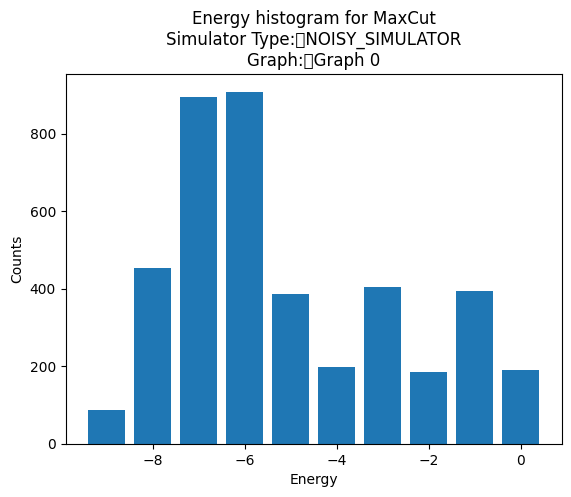

In [8]:
opt_res = sim_n.get_opt_params(graph_objs[0])
opt_res_counts = sim_n.run_circuit_optimal_params(opt_res, graph_objs[0])

In [9]:
best_cut, best_solution = sim_n.best_solution(graph_objs[0], opt_res_counts)

Best string: 0011010 with cut: 9


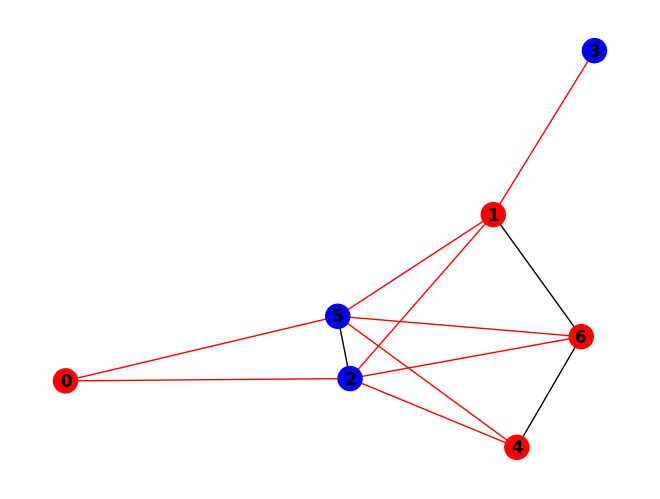

In [10]:
G = graph_objs[0].graph
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
cut_edges = [(u, v) for u, v in G.edges() if ((best_solution[u] == '0' and best_solution[v] != '0') or (best_solution[u] != '0' and best_solution[v] == '0'))]

cut_edge_color = 'red'
non_cut_edge_color = 'black'
for edge in G.edges():
    if edge in cut_edges:
        G[edge[0]][edge[1]]['color'] = cut_edge_color
    else:
        G[edge[0]][edge[1]]['color'] = non_cut_edge_color

edge_colors = [G[edge[0]][edge[1]]['color'] for edge in G.edges()]

nx.draw(G, node_color = colors, with_labels=True, font_weight='bold', edge_color=edge_colors)
plt.show()